# Thoughts on the Convergence of Hull-White Model Monte-Carlo Simulations
[Gouthaman Balaraman](http://gouthamanbalaraman.com)

I had recently written an introductory post on [simulating short rates in the Hull-White Model](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html). This [question on the QuantLib forum](http://quantlib.10058.n7.nabble.com/Matching-results-between-HW-tree-and-simulation-models-td16399.html) raised some interesting questions on the convergence of the Hull-White model simulations. In this post, I discuss the convergence of Monte-Carlo simulations using the Hull-White model.

The Hull-White Short Rate Model is defined as:

$$ dr_t = (\theta(t) - a r_t)dt + \sigma dW_t $$,
      
where $a$ and $\sigma $ are constants, and $\theta(t)$ is
chosen in order to fit the input term structure of interest rates.
Here we use QuantLib to show how to simulate the Hull-White model
and investigate some of the properties.

The variables used in this post are described below: 
- `timestep` is the number of steps used to discretize the time grid
- `hw_process` the object that defines the Hull-White process, 
- `length` is the time span of the simulation in years
- `low_discrepancy` is a boolean variable that is used to chose `Sobol` low discrepancy random or not
- `brownnian_bridge` is a boolean that choses brownian bridge for path generation 
- `num_paths` is the number of paths in the simulation
- `a` is the constant parameter in the Hull-White model
- `sigma` is the constant parameter $\sigma$ in the Hull-White model that describes volatility

In [ ]:
# <!-- collapse=True -->
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps, cumtrapz, romb
% matplotlib inline
import math

todays_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = todays_date

The `get_path_generator` function creates the a path generator. This function takes various inputs such as 


In [ ]:
# <!-- collapse=True -->
def get_path_generator(timestep, hw_process, length, 
                       low_discrepancy=False, brownian_bridge=True):
    """
    Returns a path generator
    """
    if low_discrepancy:
        usg = ql.UniformLowDiscrepancySequenceGenerator(timestep)
        rng = ql.GaussianLowDiscrepancySequenceGenerator(usg)
        seq = ql.GaussianSobolPathGenerator(
                hw_process, length, timestep, rng,brownian_bridge)
    else:
        usg = ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator())
        rng = ql.GaussianRandomSequenceGenerator(usg)
        seq = ql.GaussianPathGenerator(
                hw_process, length, timestep, rng, brownian_bridge)
    return seq

The `generate_paths` function uses the generic path generator produced by the `get_path_generator` function to return a tuple of the array of the points in the time grid and a matrix of the short rates generated.

In [3]:
# <!-- collapse=True -->
def generate_paths(num_paths, timestep, seq):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

The `generate_paths_zero_price` essentially is a wrapper around `generate_path_generator` and `generate_paths` taking all the required raw inputs. This function returns the average of zero prices from all the paths for different points in time. I wrote this out so that I can conveniently change all the required inputs and easily plot the results.

In [4]:
# <!-- collapse=True -->
def generate_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, 
                              num_paths, avg_grid_array, low_discrepancy=False, 
                              brownian_bridge=True):
    """
    This function returns a tuple (T_array, F_array), where T_array is the array 
    of points in the time grid, and F_array is the array of the average of zero 
    prices observed from the simulation.
    """
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    seq = get_path_generator(
            timestep, hw_process, length, low_discrepancy, brownian_bridge
    )
    time, paths = generate_paths(num_paths, timestep, seq)
    avgs = [(time[j],(np.mean([math.exp(-simps(paths[i][0:j], time[0:j])) 
                               for i in range(num_paths)]))) 
            for j in avg_grid_array
            ]
    return zip(*avgs)

def generate_paths_discount_factors(spot_curve_handle, a, sigma, timestep, length, 
                              num_paths, avg_grid_array, low_discrepancy=False, 
                              brownian_bridge=True):
    """
    This function returns a tuple (T_array, S_matrix), where T_array is the array 
    of points in the time grid, and S_matrix is the matrix of the spot rates for 
    each path in the different points in the time grid.
    """
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    seq = get_path_generator(
            timestep, hw_process, length, low_discrepancy, brownian_bridge
    )
    time, paths = generate_paths(num_paths, timestep, seq)
    arr = np.zeros((num_paths, len(avg_grid_array)))
    for i in range(num_paths):
        arr[i, :] =  [np.exp(-simps(paths[i][0:j], time[0:j])) for j in avg_grid_array ]
    t_array = [time[j] for j in avg_grid_array]
    return t_array, arr

def V(t,T, a, sigma):
    """ Variance of the integral of short rates, used below"""
    return sigma*sigma/a/a*(T-t + 2.0/a*math.exp(-a*(T-t)) - 
                            1.0/(2.0*a)*math.exp(-2.0*a*(T-t)) - 3.0/(2.0*a) )
    

## Factors affecting the convergence 

In order to understand the convergence of Monte-Carlo for the Hull-White model, let us compare the market discount factor,  

$$ P^M(t, T) = \exp\left(-\int_t^Tf^{M} (t,u)du\right)$$

with the expectation of the discount factors from the sample of Monte-Carlo paths,

$$P^{MC}(t,T) = E_t\left\{ e^{-\int_t^T r^{MC}(u) du} \right\}$$.

Here $f^{M}(t, T)$ is the instantaneous forward rate implied by the market, and $r^{MC}(s)$ is the instantaneous short rate from the 
Monte-Carlo simulations. The error in the Monte-Carlo simulation can be defined as:

$$ \epsilon(T) = P^M(0,T) - P^{MC}(0,T) $$ 


As a first step, let us look at the plots of $\epsilon(t)$ for different values of $a$ and $\sigma$.

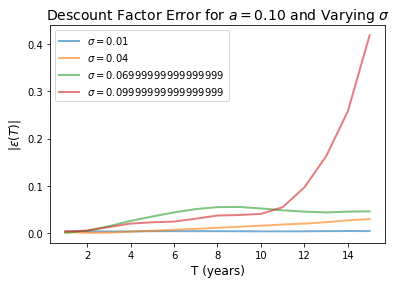

In [5]:
# <!-- collapse=True -->
# Here we vary sigma with fixed a and observe the error epsilon
# define constants 
num_paths = 500
sigma_array = np.arange(0.01,0.1,0.03)
a = 0.1
timestep = 180
length = 15 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
avg_grid_array = np.arange(12, timestep+1, 12)

# generate spot curve
spot_curve = ql.FlatForward(
    todays_date, 
    ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count
)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

#initialize plots
figure, axis = plt.subplots()
plots = []
zero_price_theory = np.array([spot_curve.discount(j*float(length)/float(timestep)) 
                              for j in avg_grid_array])
for sigma in sigma_array:
    term, zero_price_empirical = generate_paths_zero_price(
        spot_curve_handle, a, sigma, timestep, length, num_paths,
        avg_grid_array
    )
    plots += axis.plot(
        term, np.abs(zero_price_theory - np.array(zero_price_empirical)),
        lw=2, alpha=0.6, 
        label="$\sigma=$"+str(sigma)
    )

# plot legend
labels = [p.get_label() for p in plots]
legend =axis.legend(plots,labels, loc=0)#, loc=0, bbox_to_anchor=(1.1,0.4))
axis.set_xlabel("T (years)", size=12)
axis.set_ylabel("|$\epsilon(T)$|", size=12)
axis.set_title("Descount Factor Error for $a=$%0.2f and Varying $\sigma$"%a, size=14)

plt.show()

The above plot illustrates that for $\sigma=0.01$, the Monte-Carlo model shows good convergence, and the convergence gradually deteriorates as $\sigma$ increases and approaches $a$. 

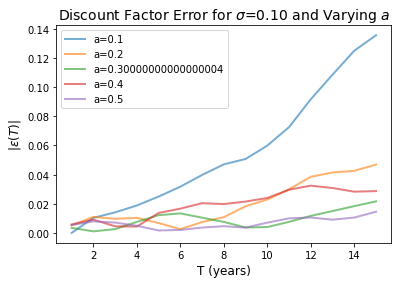

In [6]:
# <!-- collapse=True -->
# Here we vary a with fixed sigma and observe the error epsilon
#define constants
num_paths = 500
sigma = 0.1
a_array = np.arange(0.1, 0.51, 0.1)
timestep = 180
length = 15 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
avg_grid_array = np.arange(12, timestep+1, 12)

# generate spot curve
spot_curve = ql.FlatForward(
    todays_date,
    ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count
)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

#initialize plots
figure, axis = plt.subplots()
plots = []
zero_price_theory = np.array([spot_curve.discount(j*float(length)/float(timestep)) 
                              for j in avg_grid_array])
for a in a_array:
    term, zero_price_empirical = generate_paths_zero_price(
        spot_curve_handle, a, sigma, timestep, length, num_paths,
        avg_grid_array
    )
    plots += axis.plot(
        term,np.abs(zero_price_theory - np.array(zero_price_empirical)),  
        lw=2, alpha=0.6, 
        label="a="+str(a)
    )
    
# plot legend
labels = [p.get_label() for p in plots]
legend =axis.legend(plots,labels, loc=0)#, loc=0, bbox_to_anchor=(1.1,0.4))
axis.set_xlabel("T (years)", size=12)
axis.set_ylabel("|$\epsilon(T)$|", size=12)
axis.set_title("Discount Factor Error for $\sigma$=%0.2f and Varying $a$"%sigma, size=14)

plt.show()

The above plot illustrates that for $a=0.1$ the convergence of Monte-Carlo is poor, and it gradually improves as $a$ increases more than $\sigma$.

From the plots above, we observe that the convergence is good if the ratio $\sigma/a < 1$, and the convergence detiorates as the ratio $\sigma/a$ increases above unity. Now, let us try to formalize this observation from the theoretical footing of the Hull-White model.

## Distribution of Discount Factors

The Monte-Carlo approach estimates the market discount factor as the expectation of discount factors from each Monte-Carlo path. 
If distribution of discount factors has a standard deviation $\sigma_D$, then the error in our estimate of $P^{MC}(t,T)$  on using $N$ paths will be of the order of:
$$\epsilon(t,T) \approx \frac{\sigma_D}{\sqrt(N)}. $$

In other words, there are two factors at play in our Monte-Carlo estimate, the number of Monte-Carlo paths $N$ and the standard deviation of the distribution of discount factors $\sigma$. Using more Monte-Carlo paths will lead to improved convergence. But at the same time, 
the $\sigma_D$ has to be relatively small for us to get a good estimate. 

The integral of short rates can be shown to be normally distributed (refer Brigo-Mercurio, second edition page 75), and is given as 
$$ \int_t^T r(u) du | \mathcal{F}_t \sim  \mathcal{N}\left(B(t,T)[r(t)-\alpha(t)] + \ln\frac{P^M(0,t)}{P^M(0,T)} + \frac{1}{2}[V(0,T) - V(0,t)], V(t,T)\right)$$

where,
\begin{eqnarray}
B(t,T) &=& \frac{1}{a} \left[ 1 - e^{-a(T-t)}\right] \\
V(t,T) &=& \frac{\sigma^2}{a^2}\left[ T - t + \frac{2}{a}e^{-a(T-t)} - \frac{1}{2a}e^{-2a(T-t)} - \frac{3}{2a}\right]
\end{eqnarray}

Based on this result, the discount factor from the Monte-Carlo simulation of short rates

$$ P^{MC}(t, T) = \exp\left(- \int_t^T r(u) du | \mathcal{F}_t  \right)$$

will have a log-normal distribution with a standard deviation 

$$ \sigma_D(t,T) = P^M(t,T)\sqrt{e^{V(t,T)} -1 }$$

This result follows from the fact that if $X$ is a random process with a normal distribution having mean $\mu$ and standard deviation $\sigma$, then [log-normal distribution](http://en.wikipedia.org/wiki/Log-normal_distribution) $Y=e^X$ will satisfy:
\begin{eqnarray}
E(Y) &=& e^{\mu+\sigma^2/2}\\
Var(Y) &=& (e^{\sigma^2} -1 )E(Y)^2
\end{eqnarray}


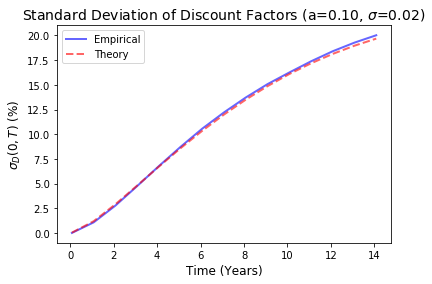

In [7]:
# <!-- collapse=True -->
#define constants
num_paths = 500
sigma = 0.02
a = 0.1
timestep = 180
length = 15 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
avg_grid_array = np.arange(1, timestep+1, 12)

# generate spot curve
spot_curve = ql.FlatForward(
    todays_date,
    ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count
)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

term, discount_factor_matrix = generate_paths_discount_factors(
        spot_curve_handle, a, sigma, timestep, length, num_paths,
        avg_grid_array
    )

vol = [np.var(discount_factor_matrix[:, i]) for i in range(len(term))]
l1 = plt.plot(term, 100*np.sqrt(vol),"b", lw=2, alpha=0.6,label="Empirical")
vol_theory = [100*np.sqrt(math.exp(V(0,T,a, sigma))-1.0) * 
              spot_curve_handle.discount(T) for T in term]
l2 = plt.plot(term, vol_theory,"r--", lw=2, alpha=0.6,label="Theory")

plots = l1+l2
labels = [p.get_label() for p in plots]
legend =plt.legend(plots,labels, loc=0)
plt.xlabel("Time (Years)", size=12)
plt.ylabel("$\sigma_D(0,T)$ (%)", size=12)
plt.title("Standard Deviation of Discount Factors "
          "(a=%0.2f, $\sigma$=%0.2f)"%(a, sigma), size=14)
plt.show()

The plot above compares the standard deviation of the discount factors $\sigma_D$ from the closed form expression with a Monte-Carlo estimate. The empirical estimate is in agreement with the theoretical expectation. We can estimate the value of $\sigma_D$ for the asymptotic limit of $T\rightarrow\infty$:

$$ \sigma_D(0, T) \approx P^M(0,T)e^{f^M(0,T)/a-\sigma^2/(4a^3)}\sqrt{e^{\sigma^2T/a^2} - 1}$$

The exponential term, $e^{\sigma^2T/a^2}$,  can become very large when $\sigma^2T/a^2$ grows above 1.
Thus we can expect good convergence when  $\sigma^2T/a^2$ remains small or close to zero for the 
time $T$ of interest to us.

The above result suggests that if the parameters $\sigma$ and $a$ are not chosen carefully, (i.e. $\sigma/a >1$) then the convergence of the simulation would be poor and the results untrustworthy.
